# Bridging Controls 

This notebook looks at understanding the role of bridging controls for batch effect normalization. In here you will find analyses that look at : 

- estimating batch effects from bridging controls
- cell type distributions 
- cell abundance considerations 

The main dataset being used is the longitudinal pilot,

| Variable   | Quantity              |
|------------|-----------------------|
| Samples    | 4 clinical, 1 bridge |
| batches    | 2                     |
| Cell Total | ~ half a million      |
| Cell Types | 13 represented        |


# Cell Type analysis 

One of the main challenges is assessing cell types & fluctuations by subject across time and batches. The datasets and libraries below are required to conduct this analysis. 

In [2]:
## load libraries and dataset
options(warn = -1)
require(hise)
require(scMerge)
require(glmnet)
require(glmmTMB)
require(data.table)
require(ggplot2)
sce <- readRDS('sceFltrd_kpGns.rds')
sce

Loading required package: hise

Loading required package: scMerge

Loading required package: glmnet

Loading required package: Matrix

Loaded glmnet 4.1-1

Loading required package: glmmTMB

Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 

Loading required package: data.table



class: SingleCellExperiment 
dim: 22758 506564 
metadata(0):
assays(2): counts logcpm
rownames(22758): ENSG00000131043 ENSG00000161204 ... ENSG00000184274
  ENSG00000223901
rowData names(19): geneid genename ... Dendriticcell.exprProp
  Platelets.exprProp
colnames(506564): 1 2 ... 518425 518426
colData names(21): barcodes batch ... mito propMito
reducedDimNames(0):
altExpNames(0):

## Cell Distribution
One key point to note about bridging controls as that they are split by batch collected at a single time point, to block against potential batch effects. 


### Total cells: Donor X Batch 

The following table demonstrates that per batch we have > 100k cells of clinical samples whereas for our bridging control we only have about 5k samples. 

    knitr::kable(table(sce$subjid, sce$batch))

|       |   X001|   X002|
|:------|------:|------:|
|IMM19  |   5395|   4304|
|PB1178 |      0| 101685|
|PB2216 |      0| 133413|
|PB5206 | 138780|      0|
|PB7626 | 122987|      0|


### Total cells: Donor X Batch X Week

The +100k samples 2 patients over 6 weeks, so a fairer is to look break them down either by week

    knitr::kable(table(sce$subjid, sce$wk))  
|       |    0|     2|     3|     4|     5|     6|     7|
|:------|----:|-----:|-----:|-----:|-----:|-----:|-----:|
|IMM19  | 9699|     0|     0|     0|     0|     0|     0|
|PB1178 |    0| 15614| 15332| 15737| 16428| 17862| 20712|
|PB2216 |    0| 17909| 24177| 22874| 22370| 18457| 27626|
|PB5206 |    0| 19459| 24146| 24424| 25431| 24724| 20596|
|PB7626 |    0| 20578| 20052| 19138| 20604| 23087| 19528|


or by average # of cells per donor per batch. 


### Cell Composition 

In [35]:
cat("\n\nAverage # Cells per donor per Batch")
rbind(table(sce$subjid, sce$batch)[1,],
table(sce$subjid, sce$batch)[-1,]/6)



Average # Cells per donor per Batch

,X001,X002
,5395.00,4304.0
PB1178,0.00,16947.5
PB2216,0.00,22235.5
PB5206,23130.00,0.0
PB7626,20497.83,0.0


### Absolute vs. Percentile Ranks

Both absolute and percentile comparisons are required when analyzing cell composition because we need to understand how cells are going to be distributed across donors but also is there enough volume to adequately correct. 

In [36]:
abs_count <- rbind(table(sce$cellType, sce$subjid),
                   colSums(table(sce$cellType, sce$subjid)))
rel_count <- rbind(prop.table(table(sce$cellType, sce$subjid),margin = 2),
                         colSums(prop.table(table(sce$cellType, sce$subjid),margin = 2)))

knitr::kable(
  list(abs_count, round(rel_count,3)),
  caption = 'Absolute vs. Relative Distributions',
  booktabs = TRUE, halign = 't'
)



Table: Absolute vs. Relative Distributions

|                       | IMM19| PB1178| PB2216| PB5206| PB7626|
|:----------------------|-----:|------:|------:|------:|------:|
|B cell progenitor      |   242|   2903|   4501|   3458|   3746|
|CD14+ Monocytes        |  2071|  14653|  31249|  19896|  19862|
|CD16+ Monocytes        |   195|   1639|   4273|   2544|   3048|
|CD4 Memory             |  1482|  15497|  24814|  25802|  14051|
|CD4 Naive              |  2447|  24923|  18034|  40762|  29217|
|CD8 effector           |  1125|  16345|  13666|  11135|  25554|
|CD8 Naive              |   707|  12583|  12611|  13901|   6892|
|Dendritic cell         |   137|    905|   1476|   1381|   1840|
|Double negative T cell |   139|   3529|   1913|   4062|   3394|
|NK cell                |   665|   3602|  14481|   7489|   9737|
|pDC                    |    24|    452|   1040|    956|    971|
|Platelets              |    10|     98|    184|    369|    500|
|pre-B cell             |   455|   4556|   5

To evaluate whether the bridging controls with $\approx$ 5k samples are representative, statistical tests like Goodness of fit tests can compare distributions. 

An empirical distribution of the cell composition can be calculated each non-bridge donor's cell type distribution by calculating relative cell quantites,

$$\text{Empirical Distribution} = \begin{bmatrix} \frac{ \text{|B Cells|} }{|C|} &  \frac{ \text{|CD14+ Cells|} }{|C|} & \cdots &  \frac{ \text{|preB Cells|} }{|C|} \end{bmatrix}^T$$

and averaging across individuals, and normalizing by the total number of cell. Then you can compare the bridge control's distribution to an empirical distribution. For the longitudinal pilot, the healthy donors all the weekly measurements were treated identically (ignoring time variation for now) to calculate & compare distributions. 


In [43]:
emp_distn <- rowMeans(rel_count[1:13,2:4])
# emp_distn
# abs_count[1:13,1]
# sum(emp_distn)
data.frame(BridgeControl=round(rel_count[1:13,1],3), 
           HealthyDonorsEmpiricalDist=round(emp_distn,3))

# # cat('\n\nConducting a Chi-square test comparing observed-to-expected ratios of cell proportions\n\n')
#  GoF <- chisq.test(x = abs_count[1:13,1], p=rowMeans(abs_count[1:13,2:4]),rescale.p = T)
#  GoF

,BridgeControl,HealthyDonorsEmpiricalDist
,<dbl>,<dbl>
B cell progenitor,0.025,0.029
CD14+ Monocytes,0.214,0.174
CD16+ Monocytes,0.020,0.022
CD4 Memory,0.153,0.175
CD4 Naive,0.252,0.225
CD8 effector,0.116,0.114
CD8 Naive,0.073,0.106
Dendritic cell,0.014,0.010
Double negative T cell,0.014,0.026


## Percentage vs. Absolute concerns

Compositionally, in the longitudinal pilot, we see that the cell types healthy donors are well represented by the bridge controls. The samples are proportionally equivalent and well-represented.  

However, we see that for rare cell types (i.e., Platelets, pDC cells), across both batches we're getting 24 and 10 cells across both batches, reducing any chance to do quality "per-celltype" batch correction. In addition, for comparisons across healthy cohorts with non-perturbed immune systems, we might expect well-represented data from the bridging controls (i.e., longitudinal pilot), however, this might not hold true for the BR1/BR2 and the covid cohorts. 

    
|                       | IMM19| PB1178| PB2216| PB5206| PB7626|
|:----------------------|-----:|------:|------:|------:|------:|
|B cell progenitor      |   242|   2903|   4501|   3458|   3746|
|CD14+ Monocytes        |  2071|  14653|  31249|  19896|  19862|
|CD16+ Monocytes        |   195|   1639|   4273|   2544|   3048|
|CD4 Memory             |  1482|  15497|  24814|  25802|  14051|
|CD4 Naive              |  2447|  24923|  18034|  40762|  29217|
|CD8 effector           |  1125|  16345|  13666|  11135|  25554|
|CD8 Naive              |   707|  12583|  12611|  13901|   6892|
|Dendritic cell         |   137|    905|   1476|   1381|   1840|
|Double negative T cell |   139|   3529|   1913|   4062|   3394|
|NK cell                |   665|   3602|  14481|   7489|   9737|
|pDC                    |    24|    452|   1040|    956|    971|
|Platelets              |    10|     98|    184|    369|    500|
|pre-B cell             |   455|   4556|   5171|   7025|   4175|
|                       |  9699| 101685| 133413| 138780| 122987|


In addition, time drift and variability across time might present another challenge to consider looking forward. 


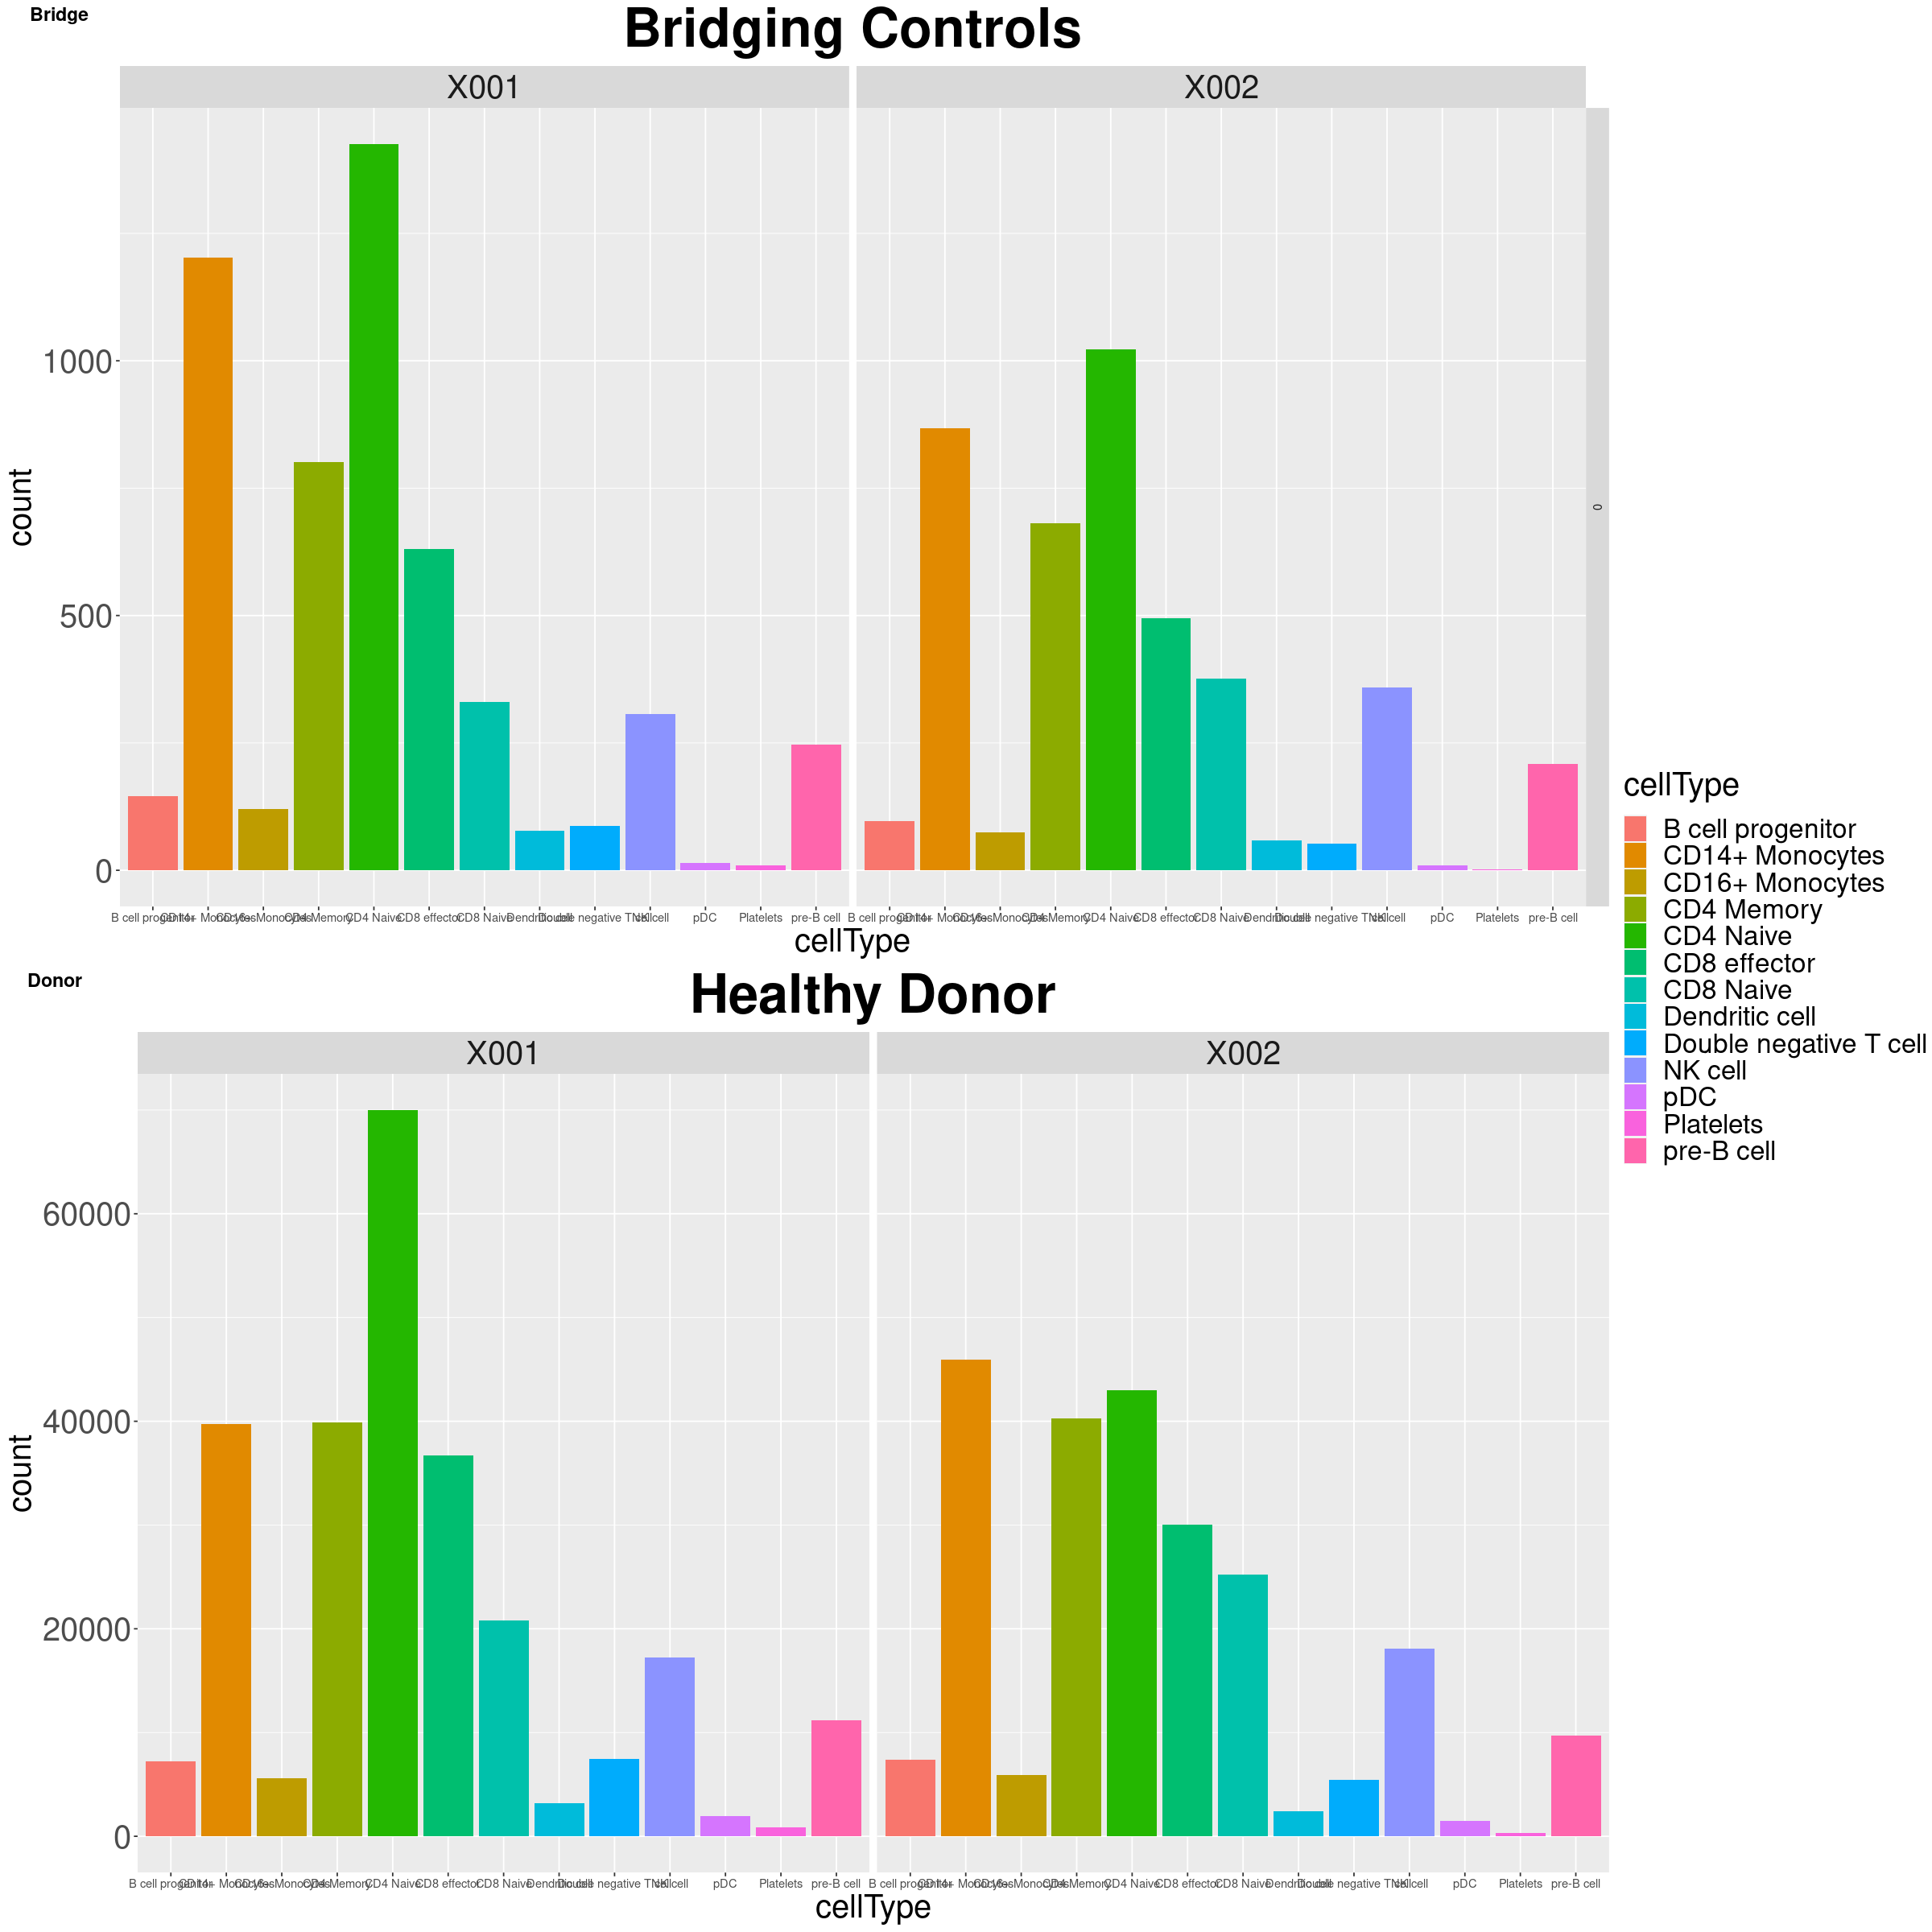

In [26]:
## make figure larger
options(repr.plot.width=20, repr.plot.height=20)
require(ggpubr)


df <- data.frame(sce@colData)

bri <- ggplot(df[df$subjid=='IMM19',], aes(x=cellType, y=..count..,
               group=cellType, fill=cellType) )+
  geom_bar(position='dodge')+
  facet_grid(Week~batch)+ggtitle('Bridging Controls') +
 theme(plot.title = element_text(size = 40, face = "bold",hjust = 0.5),
    legend.title=element_text(size=24), 
    axis.title.x=element_text(size=24), 
#     axis.text.x=element_text(size=24), 
    axis.title.y=element_text(size=24),
    strip.text.x=element_text(size=24), 
    axis.text.y=element_text(size=24), 
    legend.text=element_text(size=20))


don <- ggplot(df[df$subjid!='IMM19',], aes(x=cellType, y=..count..,
                                  group=cellType, fill=cellType) )+
  geom_bar(position='dodge')+
  facet_grid(.~batch)+ggtitle('Healthy Donor') +
 theme(plot.title = element_text(size = 40, face = "bold",hjust = 0.5),
    legend.title=element_text(size=24), 
    axis.title.x=element_text(size=24), 
    axis.text.y=element_text(size=24), 

    strip.text.x=element_text(size=24), 

#     axis.text.x=element_text(size=24), 
    axis.title.y=element_text(size=24),
    legend.text=element_text(size=20))

don2 <- ggplot(df[df$subjid!='IMM19',], aes(x=cellType, y=..count..,
                                  group=cellType, fill=cellType) )+
  geom_bar(position='dodge')+
  facet_grid(Week~batch)+ggtitle('Healthy Donor') +
 theme(plot.title = element_text(size = 40, face = "bold",hjust = 0.5),
    legend.title=element_text(size=24), 
    axis.title.x=element_text(size=24), 
    axis.text.y=element_text(size=24), 

    strip.text.x=element_text(size=24), 
    strip.text.y=element_text(size=24), 


#     axis.text.x=element_text(size=24), 
    axis.title.y=element_text(size=24),
    legend.text=element_text(size=20))

ggarrange(bri, don, labels = c("Bridge", "Donor"),
          common.legend = TRUE, legend = "right",
         ncol=1)

# ggarrange(b7don2, labels = c("Bridge", "Donor"),
#           common.legend = TRUE, legend = "right",
#          ncol=2)


In [27]:
# ## make figure larger
# options(repr.plot.width=15, repr.plot.height=14)
# require(ggpubr)

# df <- data.frame(sce@colData)
# ggplot(df, aes(x=subjid, y=..count..,
#                group=cellType, fill=cellType) )+
#   geom_bar(position='dodge')+
#   facet_grid(Week~.)


# ggplot(df[df$subj=='IMM19',], aes(x=subjid, y=..count..,
#                group=cellType, fill=cellType) )+
#   geom_bar(position='dodge')+
#   facet_grid(Week~batch)

# ggplot(df[df$subj!='IMM19',], aes(x=subjid, y=..count..,
#                                   group=cellType, fill=cellType) )+
#   geom_bar(position='dodge')+
#   facet_grid(Week~batch)


# abs <- data.table(table(sce$cellType, sce$subjid, sce$wk))
# rel <- data.table(prop.table(table(sce$cellType, sce$subjid,sce$wk),margin = 2))

# # create table format
# format.mat <- function(a){

#     colnames(a) = c('cellType','Subj','Week','Quantity')
#     options(scipen = 999)
#     a$Cohort <- 'Healthy Donors'
#     idx <- which(a$Subj==unique(a$Subj)[1])
#     a$Cohort[idx]<-'Bridging Controls'
#     a
# }

# abs<- format.mat(abs)
# rel<- format.mat(rel)

# # dcast(t(rel[, list(Avg=mean(Quantity)), by=list(Cohort, cellType)]), 

# ggplot(rel) + geom_bar(aes(x=Cohort, y=Quantity, fill=cellType, group=cellType),
#                      stat = 'identity',position='dodge')  +
#  ggtitle('Cell Composition bridge v. Controls')+
#  theme(plot.title = element_text(size = 40, face = "bold",hjust = 0.5),
#     legend.title=element_text(size=24), 
#     axis.title.x=element_text(size=24), 
#     axis.text.x=element_text(size=24), 
#     axis.title.y=element_text(size=24),
#     legend.text=element_text(size=20))

# ggplot(rel) + geom_bar(aes(x=Cohort, y=Quantity, fill=cellType, group=cellType),
#                      stat = 'identity',position='dodge')  +
# # +facet_grid(Week~.)+
#  ggtitle('Cell Composition bridge v. Controls')+
#  theme(plot.title = element_text(size = 40, face = "bold",hjust = 0.5),
#     legend.title=element_text(size=24), 
#     axis.title.x=element_text(size=24), 
#     axis.text.x=element_text(size=24), 
#     axis.title.y=element_text(size=24),
# #     axis.ticks=element_text(size=24), 
#     legend.text=element_text(size=20))





# ggplot(a) + geom_bar(aes(x=Subj, y=Quantity, fill=cellType, group=cellType),
#                      stat = 'identity',position='dodge')  +facet_grid(Week~.)+
#  ggtitle('Cell Composition by Week')+
#  theme(plot.title = element_text(size = 40, face = "bold",hjust = 0.5),
#     legend.title=element_text(size=24), 
#     axis.title.x=element_text(size=24), 
#     axis.text.x=element_text(size=24), 
#     axis.title.y=element_text(size=24),
# #     axis.ticks=element_text(size=24), 
#     legend.text=element_text(size=20))

In [35]:
cat('# cells X subject ')
table(sce$cellType, sce$wk)

# cells X subject 

                        
                             0     2     3     4     5     6     7
  B cell progenitor        242  2047  2379  2380  2614  2682  2506
  CD14+ Monocytes         2071 13129 15085 15105 11801 15122 15418
  CD16+ Monocytes          195  1706  1966  1964  2063  1863  1942
  CD4 Memory              1482 11626 13726 13377 13254 13261 14920
  CD4 Naive               2447 15629 19372 18326 20254 18817 20538
  CD8 effector            1125 11374 10535 10141 12504 11334 10812
  CD8 Naive                707  6522  7816  7234  8036  7652  8727
  Dendritic cell           137   970   923  1019   864   903   923
  Double negative T cell   139  1932  2141  2110  2232  2284  2199
  NK cell                  665  5144  5656  5967  6836  5760  5946
  pDC                       24   548   535   572   523   601   640
  Platelets                 10   148   144   279   195   272   113
  pre-B cell               455  2785  3429  3699  3657  3579  3778

Normalizations in scMerge 

$$Y_{ii} = \frac{1}{BC}\sum Y_{ibc}$$

$$Pr(X=x)\begin{cases}
\pi & X =1 \\
1-\pi & X=0
\end{cases}$$


Some of the questions and considerations you may want to look into are:

## Comparing a leukopak with ~5000 cells VS ~20K cells and assess which cell number will be appropriate to move forward with
### Comparing the celltypes commonly captured
### What are the celltypes that are under represented
 
## Comparing the 5000 cell leukopak VS 20K leukopak with a cohort/diseased sample (~20K cells) to assess which celltypes are commonly being captured and what cell types are under-represented in the leukopak.
 
## If there are celltypes (like pDCs or Plasmablasts) that are under-represented / very low in abundance in the leukopak (since there is no immune perturbation in the leukopak), how are we going to correct for batches with those celltypes, if at all the batch variation is high within specific celltypes only.
 
## FYI, with how the H5 files are labeled with celltype annotation, Plasmablasts are currently not labeled in there. You might want to try a clustering approach to capture them if you want to look at plasmablasts. I can assist you with how to identify those plasmablasts.
 
## If there is a celltype specific variation due to batch in a cohort sample, how would you know if that variation is biological VS technical, since sometimes the batch is confounded by the patient or the timepoint of the study.
 
## Can we make sure we avoid unnecessary correction / over correction of data to retain the real biological signal.
 
## After any batch correction, it would be good to perform “sanity checks” to assess if the biological signal is preserved – eg: post correction, if you do a DEG analysis between different celltypes, do you see genes expressed by the celltypes that are supposed to be expressed as a positive control.
 
## The same with DEGs between timepoints, eg: no vaccination (baseline) VS day7 of vaccination post correction, do you see genes that are supposed to be perturbed by vaccination
 
## Also, computationally, how are we going to do batch correction? Will it be all batches corrected together (which will be computationally very intensive) or is It going to be an iterative process batch by batch as the new batches come in with the previous batch as an anchor?